In [1]:
# GPU 사용 확인
import torch

if torch.cuda.is_available():
    print("✅ GPU 사용 가능:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU 사용 불가. [런타임 → 런타임 유형 변경]에서 GPU 설정 확인")

KeyboardInterrupt: 

# colab에서 다운로드 및 압축 해제

In [ ]:
# 1. gdown 설치
!pip install -U gdown

# 2. Google Drive 공유 파일 다운로드
!gdown --id 11XaLQaUtdDjmIcFHQtIzfTKaxMzLNz_7 --output /content/scin_data.zip

# 3. 압축 해제
import zipfile

zip_path = '/content/scin_data.zip'
extract_path = '/content/scin_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ 압축 해제 완료! 압축 풀린 경로:", extract_path)

# scin_cases 메타데이터 전처리

### 1. 데이터 불러오기 및 병합

In [ ]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# 1. 파일 경로 설정
cases_path = '/content/scin_data/content/scin_data/dataset/scin_cases.csv'
labels_path = '/content/scin_data/content/scin_data/dataset/scin_labels.csv'

# 2. 데이터 불러오기 및 병합
df_cases = pd.read_csv(cases_path)
df_labels = pd.read_csv(labels_path)
df = pd.merge(df_cases, df_labels, on='case_id', how='inner')
df = df[df['weighted_skin_condition_label'].astype(str) != '{}']

### 2. 기본 전처리 및 인코딩

In [ ]:
# 3. 컬럼명 소문자화
df.columns = df.columns.str.strip().str.lower()

# 4. 다중 범주 이진화 컬럼 정의
multi_keys = ['textures_', 'body_parts_', 'condition_symptoms_', 'other_symptoms_', 'race_ethnicity_']
multi_cols = [col for col in df.columns if any(key in col for key in multi_keys)]

# 5. 문자열 결측 처리
fill_str_cols = [
    'sex_at_birth', 'fitzpatrick_skin_type', 'combined_race', 'condition_duration',
    'dermatologist_fitzpatrick_skin_type_label_1',
    'dermatologist_fitzpatrick_skin_type_label_2',
    'dermatologist_fitzpatrick_skin_type_label_3'
]
for col in fill_str_cols:
    if col in df.columns:
        df[col] = df[col].fillna('unspecified').str.lower().str.strip()

# 6. age_group 인코딩
df['age_group'] = (
    df['age_group'].fillna('unknown')
    .str.lower().str.replace('age_', '', regex=False)
    .str.replace('_to_', '-', regex=False).str.strip()
)
age_order = ['0-9','10-17','18-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','unknown']
df['age_group_ordinal'] = df['age_group'].map({v: i for i, v in enumerate(age_order)}).fillna(-1).astype(int)

# 7. 성별 원-핫 인코딩
df = pd.get_dummies(df, columns=['sex_at_birth'], prefix='sex')
sex_cols = [col for col in df.columns if col.startswith('sex_')]
df[sex_cols] = df[sex_cols].astype(int)

# 8. 피부타입 인코딩
fitz_map = {'fst1': 1, 'fst2': 2, 'fst3': 3, 'fst4': 4, 'fst5': 5, 'fst6': 6, 'unspecified': 0}
fitz_cols = ['fitzpatrick_skin_type'] + [f'dermatologist_fitzpatrick_skin_type_label_{i}' for i in range(1, 4)]
for col in fitz_cols:
    df[f'{col}_encoded'] = df[col].map(fitz_map).fillna(0).astype(int)

# 9. condition_duration 인코딩
duration_order = [
    'one_day','less_than_one_week','one_to_four_weeks','one_to_three_months',
    'three_to_twelve_months','more_than_one_year','more_than_five_years',
    'since_childhood','unknown','unspecified'
]
df['condition_duration_encoded'] = df['condition_duration'].map({v: i for i, v in enumerate(duration_order)}).fillna(-1).astype(int)

# 10. 관련 카테고리 one-hot 인코딩
df['related_category'] = df['related_category'].fillna('unknown').str.lower().str.strip()
df = pd.get_dummies(df, columns=['related_category'], prefix='rc')

# 11. 다중 범주 이진화
for col in multi_cols:
    df[col] = df[col].notna().astype(int)

### 3. 이미지 및 shot type 정보 정리

In [ ]:
# 12. 이미지 shot type 인코딩 준비
image_cols = ['image_1_path', 'image_2_path', 'image_3_path']
shot_type_cols = {
    'image_1_path': [col for col in df.columns if col.startswith('image_1_shot_type')],
    'image_2_path': [col for col in df.columns if col.startswith('image_2_shot_type')],
    'image_3_path': [col for col in df.columns if col.startswith('image_3_shot_type')],
}
df['original_index'] = df.index

def is_positive(val):
    return str(val).strip().lower() in ['1', 'true', 'yes']

# 13. 이미지 long 포맷으로 변환
df_long = df.melt(
    id_vars=[col for col in df.columns if col not in image_cols],
    value_vars=image_cols,
    var_name='image_source',
    value_name='image'
)
df_long = df_long[df_long['image'].notna() & (df_long['image'].astype(str).str.strip() != '')].reset_index(drop=True)
df_long['image_num'] = df_long['image_source'].str.extract(r'image_(\d)_path')

# ✅ 14. shot_type 이름 정확히 유지한 추출
shot_type_final = []
for row in df_long.itertuples():
    img_num = row.image_num
    original_idx = row.original_index
    matching_cols = shot_type_cols.get(f'image_{img_num}_path', [])
    shot_values = df.loc[original_idx, matching_cols] if matching_cols else []
    shot_type = [col.replace(f'image_{img_num}_shot_type_', '') for col in matching_cols if is_positive(shot_values[col])]
    shot_type_final.append(shot_type)

df_long['image_shot_type_list'] = shot_type_final
mlb_shot = MultiLabelBinarizer()
shot_dummies = pd.DataFrame(mlb_shot.fit_transform(df_long['image_shot_type_list']),
                            columns=['image_shot_type_' + cls for cls in mlb_shot.classes_])
df_long = pd.concat([df_long, shot_dummies], axis=1)


### 4. 병명 멀티레이블 정리

In [ ]:
# 15. 고유 case_id 업데이트
df_long['case_id'] = df_long['case_id'].astype(str) + '_' + df_long['image_source'].str.extract(r'image_(\d)_path')[0]

# 16. 정리
original_shot_type_cols = sum(shot_type_cols.values(), [])
drop_cols = ['image_source', 'image_num', 'original_index', 'image_shot_type_list']
df_long.drop(columns=drop_cols + original_shot_type_cols, inplace=True)

# 17. 이미지 경로 정리
df_long['image'] = df_long['image'].astype(str).str.strip()
df_long = df_long[df_long['image'] != '']
df_long = df_long.drop_duplicates(subset='image', keep='first').reset_index(drop=True)

# 18. 병명 멀티레이블 파싱
def extract_multi_labels(label_str, threshold=0.3):
    try:
        label_dict = ast.literal_eval(label_str)
        return [k.strip() for k, v in label_dict.items() if v >= threshold]
    except:
        return []

df_long['multi_labels'] = df_long['weighted_skin_condition_label'].apply(extract_multi_labels)

# 19. 병명 원-핫 인코딩
mlb = MultiLabelBinarizer()
label_lists = mlb.fit_transform(df_long['multi_labels'])
label_names = ['label_' + l.replace(' ', '_').replace('/', '_').lower() for l in mlb.classes_]
label_dummies = pd.DataFrame(label_lists, columns=label_names)


### 5. 기타 변환 및 필터링

In [ ]:
# 20. TRUE/FALSE 문자열을 1/0으로 변환
bool_like_cols = df_long.columns[df_long.apply(lambda col: col.astype(str).str.upper().isin(['TRUE', 'FALSE']).all())]
for col in bool_like_cols:
    df_long[col] = df_long[col].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})

# 21. 전체 병합
df_all_labels = pd.concat([df_long.drop(columns=['weighted_skin_condition_label', 'multi_labels']), label_dummies], axis=1)

# 22. 희소 레이블 제거 + 범주형 원본 제거
label_counts = label_dummies.sum()
rare_labels = label_counts[label_counts <= 10].index.tolist()
df_filtered = df_all_labels[~df_all_labels[rare_labels].any(axis=1)].drop(columns=rare_labels).reset_index(drop=True)

remove_cat_cols = [
    'fitzpatrick_skin_type', 'age_group', 'condition_duration', 'combined_race',
    'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2',
    'dermatologist_gradable_for_skin_condition_3', 'dermatologist_skin_condition_on_label_name',
    'dermatologist_skin_condition_confidence', 'dermatologist_gradable_for_fitzpatrick_skin_type_1',
    'dermatologist_gradable_for_fitzpatrick_skin_type_2', 'dermatologist_gradable_for_fitzpatrick_skin_type_3',
    'gradable_for_monk_skin_tone_india', 'gradable_for_monk_skin_tone_us',
    'monk_skin_tone_label_india', 'monk_skin_tone_label_us',
    'dermatologist_fitzpatrick_skin_type_label_1',
    'dermatologist_fitzpatrick_skin_type_label_2',
    'dermatologist_fitzpatrick_skin_type_label_3'
]
df_all_labels.drop(columns=[col for col in remove_cat_cols if col in df_all_labels.columns], inplace=True)
df_filtered.drop(columns=[col for col in remove_cat_cols if col in df_filtered.columns], inplace=True)


### 6. 저장 및 다운로드

In [ ]:
# 23. 저장
df_all_labels.to_csv('/content/processed_scin_all_labels.csv', index=False)
df_filtered.to_csv('/content/processed_scin_filtered_labels.csv', index=False)


# 24. 다운로드
from google.colab import files
files.download('/content/processed_scin_all_labels.csv')
files.download('/content/processed_scin_filtered_labels.csv')

# scin_cases 전처리 시각화

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. 데이터 로드
df_raw_cases = pd.read_csv('/content/scin_cases.csv')
df_raw_labels = pd.read_csv('/content/scin_labels.csv')
df_raw = pd.merge(df_raw_cases, df_raw_labels, on='case_id', how='inner')

df_proc = pd.read_csv('/content/processed_scin_final2.csv')

In [3]:
# 공통 컬럼만 대상으로 필터링
common_cols = df_raw.columns.intersection(df_proc.columns)

# 결측값 개수 계산
missing_raw_common = df_raw[common_cols].isnull().sum().sort_values(ascending=False)
missing_proc_common = df_proc[common_cols].isnull().sum().sort_values(ascending=False)

# 상위 15개만 출력
print("Top 15 columns with missing values in Raw data:")
print(missing_raw_common.head(15))

print("\nTop 15 columns with missing values in Processed data:")
print(missing_proc_common.head(15))


Top 15 columns with missing values in Raw data:
race_ethnicity_native_hawaiian_or_pacific_islander    5029
race_ethnicity_middle_eastern_or_north_african        5026
race_ethnicity_other_race                             5017
race_ethnicity_prefer_not_to_answer                   4999
race_ethnicity_american_indian_or_alaska_native       4960
race_ethnicity_two_or_more_after_mitigation           4950
other_symptoms_fever                                  4943
race_ethnicity_asian                                  4937
other_symptoms_mouth_sores                            4937
body_parts_foot_sole                                  4929
other_symptoms_chills                                 4913
other_symptoms_shortness_of_breath                    4894
body_parts_palm                                       4818
body_parts_genitalia_or_groin                         4811
condition_symptoms_bleeding                           4808
dtype: int64

Top 15 columns with missing values in Processed data:

📌 Raw Sex at Birth Distribution:
  - other_or_unspecified: 2559개 (50.84%)
  - female: 1666개 (33.10%)
  - male: 807개 (16.03%)
  - unspecified: 1개 (0.02%)


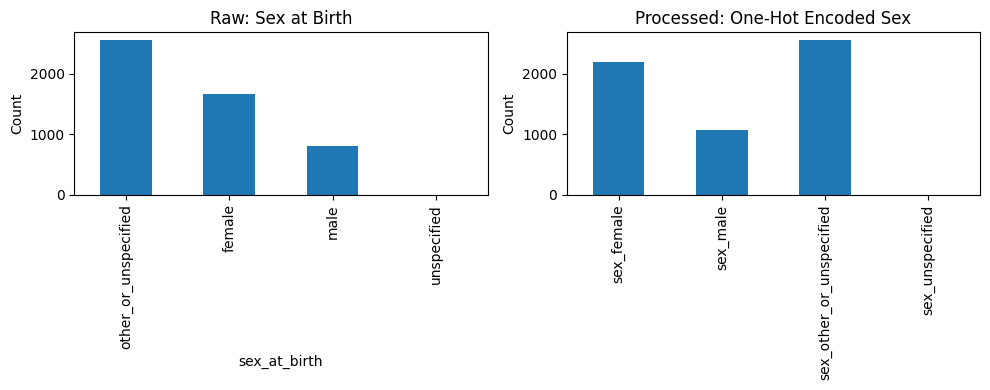

In [4]:
# 성별 분포 (One-Hot 전후)
sex_cols = [col for col in df_proc.columns if col.startswith('sex_')]

# 🔍 원본 데이터 성별 분포 분석
raw_sex_counts = df_raw['sex_at_birth'].fillna('unspecified').str.lower().value_counts()
raw_sex_percent = raw_sex_counts / raw_sex_counts.sum() * 100

# 📊 출력: 개수 + 비율
print("📌 Raw Sex at Birth Distribution:")
for sex, count in raw_sex_counts.items():
    percent = raw_sex_percent[sex]
    print(f"  - {sex}: {count}개 ({percent:.2f}%)")

# 🖼️ 시각화
plt.figure(figsize=(10, 4))

# 원본
plt.subplot(1, 2, 1)
raw_sex_counts.plot(kind='bar')
plt.title("Raw: Sex at Birth")
plt.ylabel("Count")

# 원-핫 인코딩 이후
plt.subplot(1, 2, 2)
df_proc[sex_cols].sum().plot(kind='bar')
plt.title("Processed: One-Hot Encoded Sex")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


📌 Raw Age Group Distribution:
  - age_18_to_29: 769개 (15.28%)
  - age_30_to_39: 422개 (8.38%)
  - age_40_to_49: 435개 (8.64%)
  - age_50_to_59: 322개 (6.40%)
  - age_60_to_69: 165개 (3.28%)
  - age_70_to_79: 55개 (1.09%)
  - age_unknown: 2864개 (56.90%)
  - unknown: 1개 (0.02%)


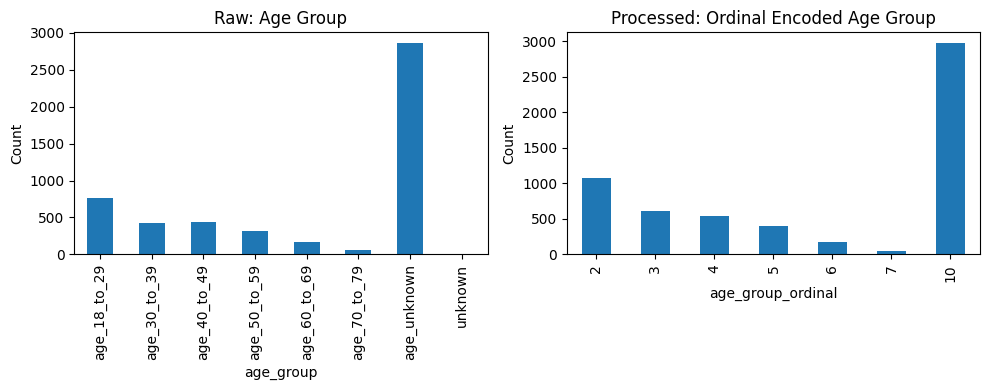

In [6]:
# 🔍 전처리 전 age_group 분포 분석
raw_age_counts = df_raw['age_group'].fillna('unknown').str.lower().value_counts().sort_index()
raw_age_percent = raw_age_counts / raw_age_counts.sum() * 100

# 📊 출력: 개수 + 비율
print("📌 Raw Age Group Distribution:")
for age, count in raw_age_counts.items():
    percent = raw_age_percent[age]
    print(f"  - {age}: {count}개 ({percent:.2f}%)")

# 🖼️ 시각화
plt.figure(figsize=(10, 4))

# 원본 age_group
plt.subplot(1, 2, 1)
raw_age_counts.plot(kind='bar')
plt.title("Raw: Age Group")
plt.ylabel("Count")

# 전처리된 ordinal 인코딩
plt.subplot(1, 2, 2)
df_proc['age_group_ordinal'].value_counts().sort_index().plot(kind='bar')
plt.title("Processed: Ordinal Encoded Age Group")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


📌 Dermatologist Fitzpatrick Skin Type Distribution:
  - FST1: 391개 (9.09%)
  - FST2: 1432개 (33.29%)
  - FST3: 1332개 (30.96%)
  - FST4: 719개 (16.71%)
  - FST5: 359개 (8.34%)
  - FST6: 69개 (1.60%)


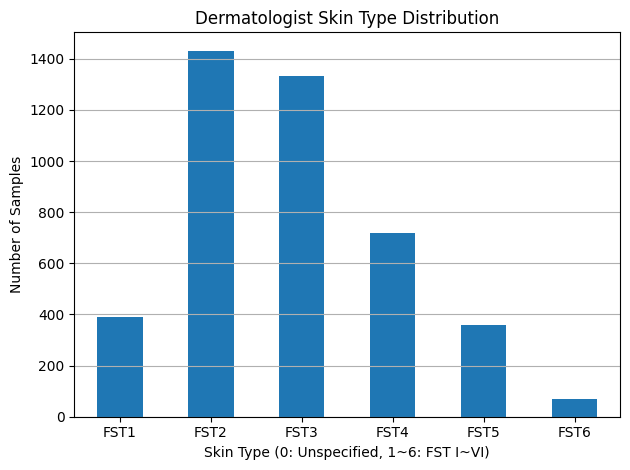

In [20]:
import matplotlib.pyplot as plt

# 시각화 대상 컬럼
col = 'dermatologist_fitzpatrick_skin_type_label_1'

if col in df_raw.columns:
    # ✅ 개수 및 비율 계산
    counts = df_raw[col].value_counts().sort_index()
    percents = counts / counts.sum() * 100

    # 📊 개수 + 비율 출력
    print("📌 Dermatologist Fitzpatrick Skin Type Distribution:")
    for label, count in counts.items():
        print(f"  - {label}: {count}개 ({percents[label]:.2f}%)")

    # 🖼️ 분포 시각화
    counts.plot(kind='bar')
    plt.title("Dermatologist Skin Type Distribution")
    plt.xlabel("Skin Type (0: Unspecified, 1~6: FST I~VI)")
    plt.ylabel("Number of Samples")
    plt.grid(axis='y')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print(f"❌ Column '{col}' not found in df_proc")


📌 Top 15 Labels:
  - Eczema: 1056개 (13.99%)
  - Allergic Contact Dermatitis: 873개 (11.56%)
  - Insect Bite: 403개 (5.34%)
  - Urticaria: 332개 (4.40%)
  - Psoriasis: 308개 (4.08%)
  - Folliculitis: 268개 (3.55%)
  - Irritant Contact Dermatitis: 249개 (3.30%)
  - Tinea: 206개 (2.73%)
  - Drug Rash: 148개 (1.96%)
  - Herpes Zoster: 142개 (1.88%)
  - Herpes Simplex: 141개 (1.87%)
  - Acute dermatitis, NOS: 124개 (1.64%)
  - Impetigo: 121개 (1.60%)
  - Hypersensitivity: 113개 (1.50%)
  - Leukocytoclastic Vasculitis: 99개 (1.31%)


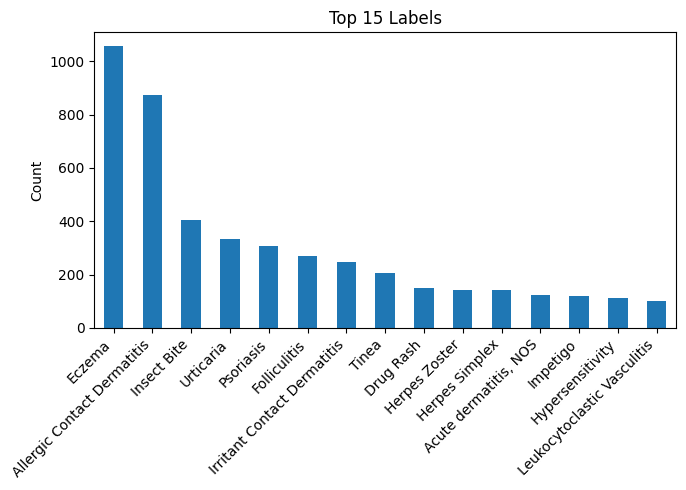

In [28]:
from collections import Counter
import ast
import pandas as pd
import matplotlib.pyplot as plt

# ✅ raw_label_series 생성
all_labels_raw = df_raw['weighted_skin_condition_label'].dropna().apply(ast.literal_eval)
flat_labels = [label for sublist in all_labels_raw for label in sublist]
raw_label_series = pd.Series(Counter(flat_labels)).sort_values(ascending=False)

# ✅ 상위 병명 수
top_k = 15
raw_total = raw_label_series.sum()

# ✅ 출력: 상위 병명 개수 및 전체 비율
print(f"📌 Top {top_k} Labels:")
for label, count in raw_label_series.head(top_k).items():
    percent = count / raw_total * 100
    print(f"  - {label}: {count}개 ({percent:.2f}%)")

# ✅ 시각화
plt.figure(figsize=(7, 5))
raw_label_series.head(top_k).plot(kind='bar')
plt.title(f"Top {top_k} Labels")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<ipython-input-26-6f3d6104c092>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_body_parts = df_body_parts.applymap(lambda x: 1 if str(x).strip().upper() == "YES" else 0)


📌 Top 15 Body Parts:
  - arm: 1707개 (21.35%)
  - leg: 1694개 (21.19%)
  - torso_front: 795개 (9.94%)
  - head_or_neck: 737개 (9.22%)
  - torso_back: 652개 (8.15%)
  - other: 543개 (6.79%)
  - back_of_hand: 521개 (6.52%)
  - foot_top_or_side: 415개 (5.19%)
  - buttocks: 391개 (4.89%)
  - genitalia_or_groin: 222개 (2.78%)
  - palm: 215개 (2.69%)
  - foot_sole: 104개 (1.30%)


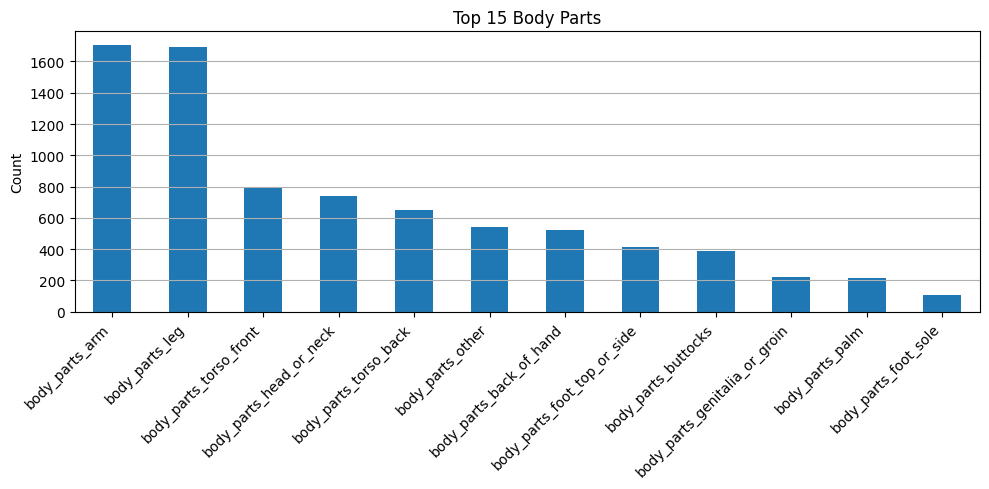

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 1. body_parts 관련 컬럼 추출
body_part_cols = [col for col in df_raw.columns if col.startswith("body_parts_")]

# ✅ 2. "YES" → 1, 나머지(null 포함) → 0으로 변환
df_body_parts = df_raw[body_part_cols].fillna("NO")
df_body_parts = df_body_parts.applymap(lambda x: 1 if str(x).strip().upper() == "YES" else 0)

# ✅ 3. 각 부위별 합계
body_part_counts = df_body_parts.sum().sort_values(ascending=False)

# ✅ 4. 전체 합
total = body_part_counts.sum()
top_k = 15

# ✅ 5. 텍스트 출력
print(f"📌 Top {top_k} Body Parts:")
for part, count in body_part_counts.head(top_k).items():
    percent = count / total * 100
    print(f"  - {part.replace('body_parts_', '')}: {count}개 ({percent:.2f}%)")

# ✅ 6. 시각화
plt.figure(figsize=(10, 5))
body_part_counts.head(top_k).plot(kind='bar')
plt.title(f"Top {top_k} Body Parts")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
